**Author**: J W Debelius<br/>
**Date**: 1 July 2015<br/>
**virtualenv**: power play

In [1]:
%%javascript
IPython.load_extensions('calico-spell-check', 'calico-document-tools')

<IPython.core.display.Javascript object>

... Simulate...

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats

from skbio.stats.power import subsample_paired_power, subsample_power
from statsmodels.stats.power import TTestIndPower

import americangut.power_plots as pp
tt = TTestIndPower()

%matplotlib inline

In [3]:
def plot_effects(calc_, lower, upper, counts, colors, ax=None, alpha=0.2,
                 labels=None):
    if ax is None:
        ax = plt.axes()
    num_effs, num_counts = calc_.shape
    for idx in xrange(4):
        ax.fill_between(x=counts, y1=lower[idx,:], y2=upper[idx, :], 
                        color=colors[idx], alpha=alpha)
        ax.plot(counts, calc_[idx, :], colors[idx])
    
    ax.set_xticklabels(map(int, ax.get_xticks()), size=12)
    ax.set_yticklabels(ax.get_yticks(), size=12)
    
    if labels is not None:
        leg = ax.legend(labels, loc=4, ncol=2)
    
    return ax

# Binary Variables

We're going to start with the simplest simulation. We'll simulate six dichitimous variables

In [4]:
np.random.seed(25)
num_obs = 500
index = np.arange(0, num_obs)
n = 1
p = 0.5
# Creates the predictor matrix
bin_sim = pd.DataFrame(np.random.binomial(n, p, size=(num_obs, 6)),
                       index=map(str, np.arange(0, num_obs)),
                       columns=['pred1', 'A', 'B', 'C', 'D', 'E'])
bin_sim['norm'] = np.random.randn(num_obs)

In [5]:
# # Creates the uniform effect with error
bin_sim['resp1'] = 4*bin_sim.pred1 + 1*bin_sim[['A', 'B', 'C']].sum(1) + bin_sim['norm']*8.15
bin_sim['resp2'] = 4*bin_sim.pred1 + 2*bin_sim[['A', 'B', 'C']].sum(1) + bin_sim['norm']*7.95
bin_sim['resp3'] = 4*bin_sim.pred1 + 4*bin_sim[['A', 'B', 'C']].sum(1) + bin_sim['norm']*7.2
bin_sim['resp4'] = 4*bin_sim.pred1 + 8*bin_sim[['A', 'B', 'C']].sum(1) + bin_sim['norm']*2.5

In [6]:
means = bin_sim.groupby('pred1').mean()
stds = bin_sim.groupby('pred1').std()
counts = bin_sim.groupby('pred1').count()['A']
eff = np.zeros(4)

In [7]:
for idx, resp in enumerate(['resp1', 'resp2', 'resp3', 'resp4']):
    eff[idx] = (np.absolute(means.loc[0, resp] - means.loc[1, resp]) / 
                np.sqrt(np.square(stds.loc[0, resp])/counts.loc[0] +
                        np.square(stds.loc[1, resp])/counts.loc[0]))

In [8]:
eff

array([ 6.44943706,  6.45358746,  6.44586317,  6.44819564])

We'll perform our tests using a case II t test, since the residuals on the data are simulated to be normal.

In [9]:
def check_comparison(ids, resp):
    x = [bin_sim.loc[id_, resp].values for id_ in ids]
    return scipy.stats.ttest_ind(*x)[1]

In [10]:
ids_ = [bin_sim.loc[bin_sim['pred1'] == 0].index, bin_sim.loc[bin_sim['pred1'] == 1].index]
for resp in ['resp1', 'resp2', 'resp3', 'resp4']:
    print check_comparison(ids_, resp)

3.93532351123e-10
3.86400682235e-10
4.08794699771e-10
3.97648590254e-10


We'll first test the relationship between the predictor variable and the power without considering any other meatadata variables.

In [11]:
bin_sim

,pred1,A,B,C,D,E,norm,resp1,resp2,resp3,resp4
0,1,1,0,0,0,0,-1.005733,-3.196722,-1.995575,0.758724,9.485668
1,1,0,1,0,0,0,0.622632,10.074451,10.949925,12.482951,13.556580
2,0,1,0,1,0,1,-0.656369,-3.349410,-1.218136,3.274141,14.359077
3,0,1,0,1,0,1,0.634435,7.170648,9.043761,12.567934,17.586088
4,1,1,0,1,0,0,-0.249951,3.962898,6.012888,10.200351,19.375122
5,0,1,1,0,0,1,-0.232987,0.101159,2.147757,6.322497,15.417534
6,1,1,1,1,0,1,0.956943,14.799084,17.607696,22.889989,30.392357
7,0,1,1,1,0,1,1.083297,11.828869,14.612210,19.799737,26.708242
8,0,1,0,1,0,0,0.087109,2.709940,4.692519,8.627187,16.217773
9,1,1,1,1,1,0,-1.276386,-3.402547,-0.147270,6.810020,24.809035


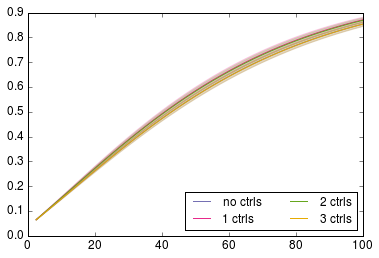

In [13]:
# Calculates the emperical power
power_params = {'counts_interval': 5,
                'max_counts': 100,
                'num_iter': 100}
test = lambda x: check_comparison(x, 'resp1')
unctrl_pwr, unctrl_cnts = subsample_power(test, [bin_sim.loc[bin_sim['pred1'] == 0].index, bin_sim.loc[bin_sim['pred1'] == 1].index],
                                          **power_params)
ctrl_pwr_1, ctrl_cnts_1 = subsample_paired_power(test, bin_sim, 'pred1', ['A'], **power_params)
ctrl_pwr_2, ctrl_cnts_2 = subsample_paired_power(test, bin_sim, 'pred1', ['A', 'B'], **power_params)
ctrl_pwr_3, ctrl_cnts_3 = subsample_paired_power(test, bin_sim, 'pred1', ['A', 'B', 'C'], **power_params)

# Extrapolates an effect size
eff_mean_1, eff_std_1 = pp.collate_effect_size([unctrl_cnts, ctrl_cnts_1, ctrl_cnts_2, ctrl_cnts_3],
                                           [unctrl_pwr, ctrl_pwr_1, ctrl_pwr_2, ctrl_pwr_3],
                                           alpha=0.05)

lower = np.zeros((6, 40))
upper = np.zeros((6, 40))
calc_ = np.zeros((6, 40))
for idx, (xj, sj) in enumerate(zip(*[eff_mean_1, eff_std_1])):
    lower[idx, :] = tt.solve_power(effect_size=xj-sj, alpha=0.05, nobs1=np.arange(2.5, 101, 2.5))
    calc_[idx, :] = tt.solve_power(effect_size=xj, alpha=0.05, nobs1=np.arange(2.5, 101, 2.5))
    upper[idx, :] = tt.solve_power(effect_size=xj+sj, alpha=0.05, nobs1=np.arange(2.5, 101, 2.5))
    
colors = np.array(['#7570b3', '#e7298a', '#66a61e', '#e6ab02'])
labels = ['no ctrls', '1 ctrls', '2 ctrls', '3 ctrls']
ax1 = plot_effects(calc_, lower, upper, np.arange(2.5, 101, 2.5),
                   colors=colors, labels=labels)

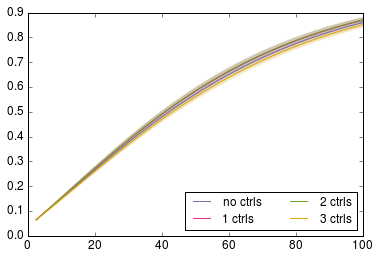

In [14]:
# Calculates the emperical power
test = lambda x: check_comparison(x, 'resp2')
unctrl_pwr, unctrl_cnts = subsample_power(test, [bin_sim.loc[bin_sim['pred1'] == 0].index, bin_sim.loc[bin_sim['pred1'] == 1].index],
                                          **power_params)
ctrl_pwr_1, ctrl_cnts_1 = subsample_paired_power(test, bin_sim, 'pred1', ['A'], **power_params)
ctrl_pwr_2, ctrl_cnts_2 = subsample_paired_power(test, bin_sim, 'pred1', ['A', 'B'], **power_params)
ctrl_pwr_3, ctrl_cnts_3 = subsample_paired_power(test, bin_sim, 'pred1', ['A', 'B', 'C'], **power_params)

# Extrapolates an effect size
eff_mean_2, eff_std_2 = pp.collate_effect_size([unctrl_cnts, ctrl_cnts_1, ctrl_cnts_2, ctrl_cnts_3],
                                           [unctrl_pwr, ctrl_pwr_1, ctrl_pwr_2, ctrl_pwr_3],
                                           alpha=0.05)

lower = np.zeros((6, 40))
upper = np.zeros((6, 40))
calc_ = np.zeros((6, 40))
for idx, (xj, sj) in enumerate(zip(*[eff_mean_2, eff_std_2])):
    lower[idx, :] = tt.solve_power(effect_size=xj-sj, alpha=0.05, nobs1=np.arange(2.5, 101, 2.5))
    calc_[idx, :] = tt.solve_power(effect_size=xj, alpha=0.05, nobs1=np.arange(2.5, 101, 2.5))
    upper[idx, :] = tt.solve_power(effect_size=xj+sj, alpha=0.05, nobs1=np.arange(2.5, 101, 2.5))

colors = np.array(['#7570b3', '#e7298a', '#66a61e', '#e6ab02'])

labels = ['no ctrls', '1 ctrls', '2 ctrls', '3 ctrls']
ax2 = plot_effects(calc_, lower, upper, np.arange(2.5, 101, 2.5),
                   colors=colors, labels=labels)

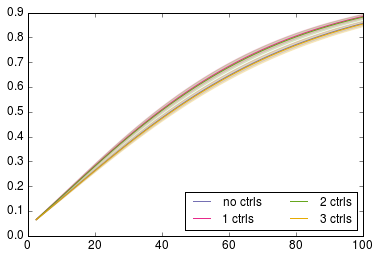

In [19]:
# Calculates the emperical power
power_params = {'counts_interval': 5,
                'max_counts': 100,
                'num_iter': 100}
test = lambda x: check_comparison(x, 'resp3')
unctrl_pwr, unctrl_cnts = subsample_power(test, [bin_sim.loc[bin_sim['pred1'] == 0].index, bin_sim.loc[bin_sim['pred1'] == 1].index],
                                          **power_params)
ctrl_pwr_1, ctrl_cnts_1 = subsample_paired_power(test, bin_sim, 'pred1', ['A'], **power_params)
ctrl_pwr_2, ctrl_cnts_2 = subsample_paired_power(test, bin_sim, 'pred1', ['A', 'B'], **power_params)
ctrl_pwr_3, ctrl_cnts_3 = subsample_paired_power(test, bin_sim, 'pred1', ['A', 'B', 'C'], **power_params)

# Extrapolates an effect size
eff_mean_3, eff_std_3 = pp.collate_effect_size([unctrl_cnts, ctrl_cnts_1, ctrl_cnts_2, ctrl_cnts_3],
                                           [unctrl_pwr, ctrl_pwr_1, ctrl_pwr_2, ctrl_pwr_3],
                                           alpha=0.05)
 
lower = np.zeros((6, 40))
upper = np.zeros((6, 40))
calc_ = np.zeros((6, 40))
for idx, (xj, sj) in enumerate(zip(*[eff_mean_3, eff_std_3])):
    lower[idx, :] = tt.solve_power(effect_size=xj-sj, alpha=0.05, nobs1=np.arange(2.5, 101, 2.5))
    calc_[idx, :] = tt.solve_power(effect_size=xj, alpha=0.05, nobs1=np.arange(2.5, 101, 2.5))
    upper[idx, :] = tt.solve_power(effect_size=xj+sj, alpha=0.05, nobs1=np.arange(2.5, 101, 2.5))


colors = np.array(['#7570b3', '#e7298a', '#66a61e', '#e6ab02'])

labels = ['no ctrls', '1 ctrls', '2 ctrls', '3 ctrls',
          '4 ctrls', '5 ctrls']
ax3 = plot_effects(calc_, lower, upper, np.arange(2.5, 101, 2.5),
                        colors=colors, labels=labels)

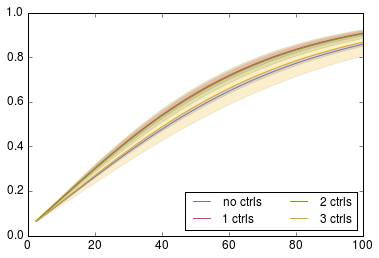

In [15]:
# Calculates the emperical power
power_params = {'counts_interval': 5,
                'max_counts': 100,
                'num_iter': 100}
test = lambda x: check_comparison(x, 'resp4')
unctrl_pwr, unctrl_cnts = subsample_power(test, [bin_sim.loc[bin_sim['pred1'] == 0].index, bin_sim.loc[bin_sim['pred1'] == 1].index],
                                          **power_params)
ctrl_pwr_1, ctrl_cnts_1 = subsample_paired_power(test, bin_sim, 'pred1', ['A'], **power_params)
ctrl_pwr_2, ctrl_cnts_2 = subsample_paired_power(test, bin_sim, 'pred1', ['A', 'B'], **power_params)
ctrl_pwr_3, ctrl_cnts_3 = subsample_paired_power(test, bin_sim, 'pred1', ['A', 'B', 'C'], **power_params)

# Extrapolates an effect size
eff_mean_4, eff_std_4 = pp.collate_effect_size([unctrl_cnts, ctrl_cnts_1, ctrl_cnts_2, ctrl_cnts_3],
                                           [unctrl_pwr, ctrl_pwr_1, ctrl_pwr_2, ctrl_pwr_3],
                                           alpha=0.05)

lower = np.zeros((6, 40))
upper = np.zeros((6, 40))
calc_ = np.zeros((6, 40))
for idx, (xj, sj) in enumerate(zip(*[eff_mean_4, eff_std_4])):
    lower[idx, :] = tt.solve_power(effect_size=xj-sj, alpha=0.05, nobs1=np.arange(2.5, 101, 2.5))
    calc_[idx, :] = tt.solve_power(effect_size=xj, alpha=0.05, nobs1=np.arange(2.5, 101, 2.5))
    upper[idx, :] = tt.solve_power(effect_size=xj+sj, alpha=0.05, nobs1=np.arange(2.5, 101, 2.5))
    
colors = np.array(['#7570b3', '#e7298a', '#66a61e', '#e6ab02'])
labels = ['no ctrls', '1 ctrls', '2 ctrls', '3 ctrls']
ax4 = plot_effects(calc_, lower, upper, np.arange(2.5, 101, 2.5),
                        colors=colors, labels=labels)

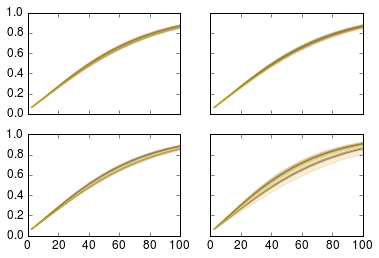

In [20]:
effects = [(eff_mean_1, eff_std_1), (eff_mean_2, eff_std_2), (eff_mean_3, eff_std_3), (eff_mean_4, eff_std_4)]
fig2 = plt.figure()

for i, (eff_mean, eff_std) in enumerate(effects):
    ax = fig2.add_subplot(2, 2, i+1)
    lower = np.zeros((4, 40))
    upper = np.zeros((4, 40))
    calc_ = np.zeros((4, 40))
    for idx, (xj, sj) in enumerate(zip(*[eff_mean, eff_std])):
        lower[idx, :] = tt.solve_power(effect_size=xj-sj, alpha=0.05, nobs1=np.arange(2.5, 101, 2.5))
        calc_[idx, :] = tt.solve_power(effect_size=xj, alpha=0.05, nobs1=np.arange(2.5, 101, 2.5))
        upper[idx, :] = tt.solve_power(effect_size=xj+sj, alpha=0.05, nobs1=np.arange(2.5, 101, 2.5))
    
    plot_effects(calc_, lower, upper, np.arange(2.5, 101, 2.5),
                 colors=colors, ax=ax)
    ax.set_ylim([0, 1])
    if i in {1, 3}:
        ax.set_yticklabels('')
    else:
        ax.set_yticklabels(ax.get_yticks(), size=12)
    if i in {0, 1}:
        ax.set_xticklabels('')



,resp1,resp2,resp3,resp4
pred1,,,,
0,1.468508,4.263418,7.841190,15.437917
1,6.647214,9.455163,11.719078,19.420977
